In [2]:
import numpy as np
import pandas as pd
import random
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MultipleLocator

from scipy import optimize
from scipy.interpolate import UnivariateSpline
from scipy import fftpack


import pylab

1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



In [29]:
#code ex1

####load the dataset
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]

#compute then the cumulative probability 
cprob = (np.arange(1,years_nb+1))/(years_nb + 1)
#year n/ all years +1 

#sort the maximum speeds from the data
max_speeds_sorted = np.sort(max_speeds)

#Use then the UnivariateSpline from scipy.interpolate to define a quantile function 
quantile = UnivariateSpline(cprob, max_speeds_sorted)   

#thus estimate the probabilities
fifty_prob = 1. - 0.02
fifty_wind = quantile(fifty_prob)

print("The storm wind speed occurring every 50 years evaluated is: {:0.2f}".format(fifty_wind))



The storm wind speed occurring every 50 years evaluated is: 32.98


2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

Time offset for min temperatures: 6.16
Time offset for max temperatures: 5.67


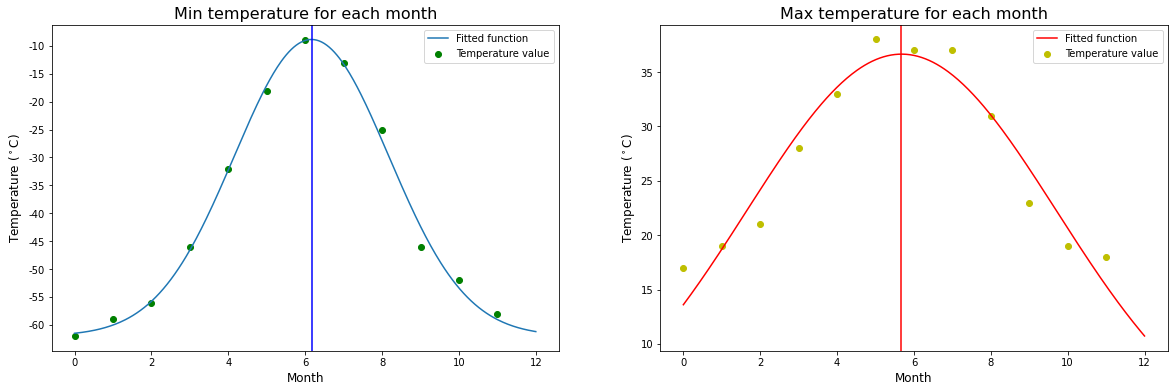

In [226]:
temp_max=np.array([17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18])
temp_min=np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
tick=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
months=np.arange(12)

#Plot these temperature extremes.
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))

# Set the locator
ax1.scatter(months,temp_min, color="g", label='Temperature value')
ax1.set_title("Min temperature for each month",fontsize=16)
ax1.set_ylabel("Temperature ($^\circ$C)",fontsize=12)
ax1.set_xlabel("Month",fontsize=12)
ax1.yaxis.set_major_locator(MultipleLocator(5))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%d'))


ax2.scatter(months,temp_max, color="y",label='Temperature value')
ax2.set_title("Max temperature for each month",fontsize=16)
ax2.set_ylabel("Temperature ($^\circ$C)",fontsize=12)
ax2.set_xlabel("Month",fontsize=12)

 
#Fit this function to the data with scipy.optimize.curve_fit().
def gauss(x, mu, sigma,a):
    return a*np.exp((-1/2)*((x-mu)/(sigma))**2)


#Plot the result. Is the fit reasonable? If not, why? 
#With the gaussian function choosen we obtein a reasonable fit for the min temperature case,
#for the mac temperature case instead there might be a better fitting function,.

#min
offset=np.abs(temp_min.min())
t_min, cov_min = optimize.curve_fit(gauss, months, temp_min+offset, maxfev=500000)
func_min= gauss(days, t_min[0], t_min[1], (t_min[2]))
ax1.plot(days,func_min-offset, label='Fitted function')
ax1.legend()

#max
offset=np.abs(temp_max.max())
t_max, cov_max = optimize.curve_fit(gauss, months, temp_max)
days = np.linspace(0, 12, num=365)
func_max=gauss(days, t_max[0], t_max[1], t_max[2])
ax2.plot(days,func_max,color="r",label='Fitted function')
ax2.legend()

#Is the time offset for min and max temperatures the same within the fit accuracy?
time_offset_min=days[np.argmax(func_min)] #days[index with the max]=>time offset line
time_offset_max=days[np.argmax(func_max)]

ax1.axvline(time_offset_min,color="b") #min line
ax2.axvline(time_offset_max,color="r") #max line

print("Time offset for min temperatures: {:0.2f}".format(time_offset_min))
print("Time offset for max temperatures: {:0.2f}".format(time_offset_max))
#Reference value: 6
#The time offset for min and max temperatures IS OR NOT? the same within the fit accuracy. FIT ACCURACY????


3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


scipy.optimize.basinhopping
global minimum: x = [-0.0898, 0.7127], f(x0) = -1.0316 with initial guest  [-1.   0.5]
With scipy.optimize.minimize
global minimum: x = [-0.0899, 0.7126], f(x0) = -1.0316 with initial guest  [-1.   0.5]
scipy.optimize.basinhopping
global minimum: x = [-0.0898, 0.7127], f(x0) = -1.0316 with initial guest  [0, 0]


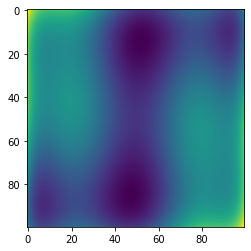

In [71]:
from scipy.optimize import basinhopping

#from scipy.optimize.basinhopping reference guide define the 2D with the variable in a vector
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html

def func(x):
    f=(4-2.1*x[0]**2+(x[0]**4/3))*x[0]**2+x[0]*x[1]+(4*x[1]**2-4)*x[1]**2
    d=np.zeros(2)
    d[0]=8*x[0]+(4)*(-2.1)*x[0]**3+2*x[0]**5+x[1] #partial d erivate wrt x
    d[1]=x[0]+(4*4*x[1]**3)+(-4*2*x[1]) #partial derivate wrt y
    return f, d

x0 = np.array([-1.0,0.5]) 
minimizer_kwargs = {"method":"L-BFGS-B", "jac":True}
ret = basinhopping(func, x0, minimizer_kwargs=minimizer_kwargs,niter=200)

##How many global minima are there, and what is the function value at those points?
print("scipy.optimize.basinhopping")
print("global minimum: x = [%.4f, %.4f], f(x0) = %.4f" % (ret.x[0],ret.x[1],ret.fun), "with initial guest ", x0)
#print("\n")


#Use scipy.optimize.minimize(), optionally trying out several of its methods.
####from scipy.optimize import minimize
def f(x):
    f=(4-2.1*x[0]**2+(x[0]**4/3))*x[0]**2+x[0]*x[1]+(4*x[1]**2-4)*x[1]**2
    return f
x_0 = np.array([-1.0,0.5]) 
res = minimize(f, x_0, method='nelder-mead') 
print("With scipy.optimize.minimize")
print("global minimum: x = [%.4f, %.4f], f(x0) = %.4f" % (res.x[0],res.x[1],res.fun), "with initial guest ", x_0)


#TRY OUT OTHERS METHOOOOOOOOOOOD EVENTUAAAALYYYYYYYYYYYYYYY------------------------------


#What happens for an initial guess of (𝑥,𝑦)=(0,0) ?
x0 = [0,0] #initial guess
minimizer_kwargs = {"method":"L-BFGS-B", "jac":True}
ret = basinhopping(func, x0, minimizer_kwargs=minimizer_kwargs,niter=200)
print("scipy.optimize.basinhopping")
print("global minimum: x = [%.4f, %.4f], f(x0) = %.4f" % (ret.x[0],ret.x[1],ret.fun), "with initial guest ", x0)
#We get the same result



#Use numpy.meshgrid() and pylab.imshow() to find visually the regions. TO DOOOOOOOOOO
def fxy(x,y):
    return (4-2.1*x**2+(x**4/3))*x**2+x*y+(4*y**2-4)*y**2

x = np.linspace(-2, 2, 100)
y = np.linspace(-1, 1, 100)
xx, yy = np.meshgrid(x, y, sparse=True)
z=fxy(xx,yy)
fig, ax1 = plt.subplots(figsize=(5, 4))
ax1.imshow(z)   #NON TORNAAAAAAAAAAAAAAAAAA

####CAMPIARE FARE CON IMSHOW! pylab.imshow() -------------------------------------------------
#fig, ax1 = plt.subplots(figsize=(5, 4))
###contourmap = ax1.contourf(x,y,z)
###fig.colorbar(contourmap)
###ax1.imshow()
###ax1.plot(ret.x[0],ret.x[1], 'ro')
###


4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

<ipython-input-78-109967ce6cc5>:21: RuntimeWarning: divide by zero encountered in true_divide
  period=1/freq


Text(0, 0.5, 'Power ($10^4$)')

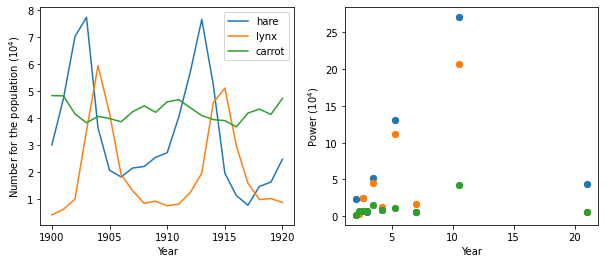

In [78]:
#code ex4

# Loading the data of populations
dataset = np.loadtxt('populations.txt') #year,hares,lynx,carrot
years = dataset[:, 0] 
populations = dataset[:, 1:] #hares,lynx,carrot

#plot dataset
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(years, populations * 1e-4)
ax1.set_xlabel("Year") 
ax1.set_ylabel("Number for the population ($10^4$)")
ax1.legend(["hare", "lynx", "carrot"], loc="upper right")


#fft of the populations
ft=fftpack.fft(populations, axis=0)
power=np.abs(ft)
time_step=years[1]-years[0]
freq=fftpack.fftfreq(populations.shape[0], d=time_step)
period=1/freq

ax2.plot(np.abs(period), power*1e-4, 'o') 
ax2.set_xlabel("Year") 
ax2.set_ylabel("Power ($10^4$)") 

#COOOOOOOOOOOOOOOMMMMEEEEEEENTOOOO

#componente in frequenza con fft delle varie popalazioni per i vari anni e vedere quale ha il modulo maggiore(dove ho il picco)
#dove ho il picco di potenza di ft

#plottare modulo in funzione del periodo(anni) : periodo calcolarlo come l'inverso dele frequenze che si ottengono 
#con la funzione di scipy fftfreq


#ABS(fft(population))  potenze _> modulo 
#print(ft)

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

Text(0.5, 1.0, 'Modified image')

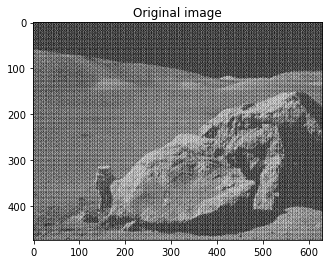

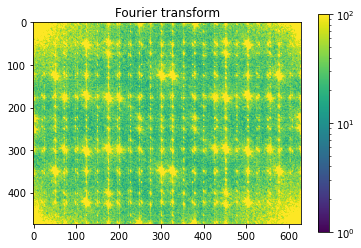

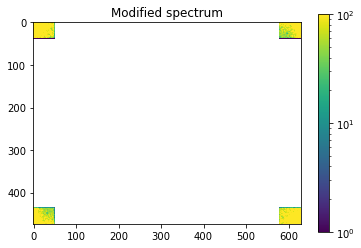

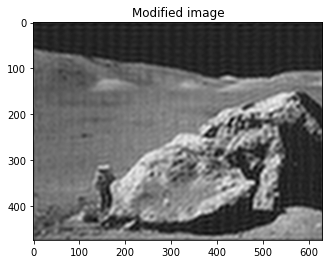

In [118]:
#code ex5 

#load the image using pylab.imread()
img=pylab.imread('moonlanding.png')
plt.figure
plt.imshow(img, plt.cm.gray)
plt.title("Original image")


##Find and use the 2-D FFT function in scipy.fftpack 
fft2D=fftpack.fft2(img)

#and plot the spectrum (Fourier transform of) the image.
power=np.abs(fft2D)

def plot_spectrum(fft):
    from matplotlib.colors import LogNorm
    plt.imshow(np.abs(fft), norm=LogNorm(vmin=1, vmax=100)) #high-frequency parto to stand out
    plt.colorbar()

plt.figure()
plot_spectrum(fft2D)
plt.title("Fourier transform")


#Do you have any trouble visualising the spectrum? If so, why?
#RISPONDEREEEEEEEEEEEEEEEEEEEEEEEEE-----------------------------------------------------


##The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part 
#of the spectrum, set some of those components to zero (use array slicing)

fft2D_cp=fft2D.copy()
rows, columns= fft2D_cp.shape

#select the high-frequency part at the extremes of the image
fraction=0.08
fft2D_cp[int(rows*fraction):int(rows*(1-fraction))]=0 #rows
fft2D_cp[:, int(columns*fraction):int(columns*(1-fraction))]=0 #columns

plt.figure()
plot_spectrum(fft2D_cp)
plt.title("Modified spectrum")

##Apply the inverse Fourier transform to see the resulting image.
new_im = fftpack.ifft2(fft2D_cp).real
plt.figure()
plt.imshow(new_im, plt.cm.gray)
plt.title("Modified image")





